In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
sys.path.insert(0,'/content/gdrive/MyDrive/Deep-Flow-Prediction/train')

In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

In [4]:
import os, sys, random
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.optim as optim

from DfpNet import TurbNetG, weights_init
import dataset
import utils

In [5]:
wandb.init(project="unet-training")
cfg = wandb.config
cfg.update({"cavit_number" : 'False','expo':5})

wandb: Currently logged in as: biradeep (use `wandb login --relogin` to force relogin)


In [ ]:
#dir_train       = r'/content/gdrive/MyDrive/train_hydro_paper/train/' 
#dir_test        = r'/content/gdrive/MyDrive/train_hydro_paper/test/' 

In [6]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
######## Settings ########

# number of training iterations
iterations = 10000
# batch size
batch_size = 10
# learning rate, generator
lrG = 0.0006
# decay learning rate?
decayLr = True
# channel exponent to control network size
expo = 5
# data set config
prop=None # by default, use all from "../data/train"
#prop=[1000,0.75,0,0.25] # mix data from multiple directories
# save txt files with per epoch loss?
saveL1 = False

##########################

In [8]:
prefix = ""
if len(sys.argv)>1:
    prefix = sys.argv[1]
    print("Output prefix: {}".format(prefix))

dropout    = 0.      # note, the original runs from https://arxiv.org/abs/1810.08217 used slight dropout, but the effect is minimal; conv layers "shouldn't need" dropout, hence set to 0 here.
doLoad     = ""      # optional, path to pre-trained model

print("LR: {}".format(lrG))
print("LR decay: {}".format(decayLr))
print("Iterations: {}".format(iterations))
print("Dropout: {}".format(dropout))


Output prefix: -f
LR: 0.0006
LR decay: True
Iterations: 10000
Dropout: 0.0


In [9]:
seed = random.randint(0, 2**32 - 1)
print("Random seed: {}".format(seed))
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic=True # warning, slower

Random seed: 2417497033


In [10]:
sys.path.insert(0,'/content/gdrive/MyDrive/segment_fluids')

In [11]:
from data_ import Dataset_

dir_train = r'/content/gdrive/MyDrive/Removed_train_hydro_2/*npz'

data_train        = Dataset_(dir_=dir_train,device=device,ro=1000.)
data_train.files_ = data_train.files_[:1078]

data_test         = Dataset_(dir_=dir_train,device=device,ro=1000.)
data_test.files_  = data_test.files_[1078:]

trainLoader = DataLoader(data_train,batch_size=10,drop_last=True)
valiLoader  = DataLoader(data_test,batch_size=1)

print("Training batches: {}".format(len(trainLoader)))
print("Validation batches: {}".format(len(valiLoader)))

Training batches: 107
Validation batches: 270


In [13]:
len(data_test)

270

In [ ]:
for a,b in trainLoader:
  break

In [ ]:
# create pytorch data object with dfp dataset
data = dataset.TurbDataset(prop, shuffle=1,dataDir=dir_train,dataDirTest=dir_test)
trainLoader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
print("Training batches: {}".format(len(trainLoader)))
dataValidation = dataset.ValiDataset(data)
valiLoader = DataLoader(dataValidation, batch_size=1, shuffle=False, drop_last=True) 
print("Validation batches: {}".format(len(valiLoader)))

In [15]:
# setup training
epochs = int(iterations/len(trainLoader) + 0.5)
netG = TurbNetG(channelExponent=expo, dropout=dropout)
print(netG) # print full net
model_parameters = filter(lambda p: p.requires_grad, netG.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Initialized TurbNet with {} trainable params ".format(params))

netG.apply(weights_init)
if len(doLoad)>0:
    netG.load_state_dict(torch.load(doLoad))
    print("Loaded model "+doLoad)
netG.cuda()

criterionL1 = nn.L1Loss()
criterionL1.cuda()

optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(0.5, 0.999), weight_decay=0.0)

targets = Variable(torch.FloatTensor(batch_size, 3, 128, 128))
inputs  = Variable(torch.FloatTensor(batch_size, 3, 128, 128))
targets = targets.cuda()
inputs  = inputs.cuda()

##########################

TurbNetG(
  (layer1): Sequential(
    (layer1_conv): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (layer2): Sequential(
    (layer2_leakyrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (layer2_conv): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (layer2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2b): Sequential(
    (layer2b_leakyrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (layer2b_conv): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (layer2b_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (layer3_leakyrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (layer3_conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (layer3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer4): Sequential(
    (layer4_le

In [16]:
print(epochs)

93


In [17]:
import math

In [18]:
# compute learning rate with decay in second half
def computeLR(i,epochs, minLR, maxLR):
    if i < epochs*0.5:
        return maxLR
    e = (i/float(epochs)-0.5)*2.
    # rescale second half to min/max range
    fmin = 0.
    fmax = 6.
    e = fmin + e*(fmax-fmin)
    f = math.pow(0.5, e)
    return minLR + (maxLR-minLR)*f

In [19]:
def relative_error(output_, target_, mask_, alpha=0.1, eps=1e-6):
    '''Input:  output_, target_ with shape [1 * C * HIGHT * WIDTH] and mask [1 * HIGHT *WIDTH]
       Output: relative error with shape 1 * C '''

    '''Number of channels vary depending on if void fraction is calculated or not'''
    n_channels = target_.shape[1]
    diff_ = abs(target_ - output_)

    mask_ = torch.cat([mask_.unsqueeze(1)] * n_channels, dim=1)
    '''mask pixels inside the airfoil'''
    masked_diff_ = torch.masked_select(diff_, ~(mask_.bool()))
    masked_target = torch.masked_select(abs(target_), ~(mask_.bool())) + eps

    error = masked_diff_ / masked_target
    l = len(error)
    error = error.view(n_channels, int(l / n_channels))
    error_indic_ = error > alpha

    return error_indic_.sum(dim=1) / (l / n_channels)


In [20]:
for epoch in range(epochs):
    print("Starting epoch {} / {}".format((epoch+1),epochs))

    netG.train()
    L1_accum = 0.0
    for i, traindata in enumerate(trainLoader, 0):
        inputs_cpu, targets_cpu  = traindata
        #targets_cpu, inputs_cpu = targets_cpu.float().cuda(), inputs_cpu.float().cuda()
        #inputs.data.resize_as_(inputs_cpu).copy_(inputs_cpu)
        #targets.data.resize_as_(targets_cpu).copy_(targets_cpu)

        # compute LR decay
        if decayLr:
            currLr = computeLR(epoch, epochs, lrG*0.1, lrG)
            if currLr < lrG:
                for g in optimizerG.param_groups:
                    g['lr'] = currLr

        netG.zero_grad()
        #gen_out = netG(inputs)
        gen_out = netG(inputs_cpu[:,1:,:,:])
        #lossL1 = criterionL1(gen_out, targets)
        lossL1 = criterionL1(gen_out, targets_cpu[:,:3,:,:])
        lossL1.backward()

        optimizerG.step()

        lossL1viz = lossL1.item()
        L1_accum += lossL1viz

        if i==len(trainLoader)-1:
            logline = "Epoch: {}, batch-idx: {}, L1: {}\n".format(epoch, i, lossL1viz)
            print(logline)

    wandb.log({'Train_loss':L1_accum/len(trainLoader),'Epoch':epoch})


    # validation
    netG.eval()
    R_Error     = torch.zeros(size=(1,3),device=device)
    L1val_accum = 0.0
    for i, validata in enumerate(valiLoader, 0):
        inputs_cpu, targets_cpu  = validata
        #targets_cpu, inputs_cpu = targets_cpu.float().cuda(), inputs_cpu.float().cuda()
        #inputs.data.resize_as_(inputs_cpu).copy_(inputs_cpu)
        #targets.data.resize_as_(targets_cpu).copy_(targets_cpu)

        outputs = netG(inputs_cpu[:,1:,:,:])
        outputs_cpu = outputs.data.cpu().numpy()

        lossL1 = criterionL1(outputs, targets_cpu[:,:3,:,:])
        L1val_accum += lossL1.item()
        R_Error         += relative_error(outputs,targets_cpu[:,:3,:,:],inputs_cpu[:,3,:,:])
        '''
        if i==0:
            input_ndarray = inputs_cpu[:,1:,:,:].cpu().numpy()[0]
            v_norm = ( np.max(np.abs(input_ndarray[0,:,:]))**2 + np.max(np.abs(input_ndarray[1,:,:]))**2 )**0.5

            outputs_denormalized = data.denormalize(outputs_cpu[0], v_norm)
            targets_denormalized = data.denormalize(targets_cpu.cpu().numpy()[0], v_norm)
            utils.makeDirs(["results_train"])
            utils.imageOut("results_train/epoch{}_{}".format(epoch, i), outputs_denormalized, targets_denormalized, saveTargets=True)
        '''
    # data for graph plotting
    L1_accum    /= len(trainLoader)
    L1val_accum /= len(valiLoader)
    '''
    if saveL1:
        if epoch==0: 
            utils.resetLog(prefix + "L1.txt"   )
            utils.resetLog(prefix + "L1val.txt")
        utils.log(prefix + "L1.txt"   , "{} ".format(L1_accum), False)
        utils.log(prefix + "L1val.txt", "{} ".format(L1val_accum), False)
    '''
    E_P, E_V_x, E_V_y  = R_Error[0]/len(valiLoader)

    wandb.log({'Test_loss':L1val_accum,'Epoch':epoch,\
               'E_P':E_P,'E_V_x':E_V_x,'E_V_y':E_V_y})

torch.save(netG.state_dict(), prefix + "modelG" )

Starting epoch 1 / 93


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Epoch: 0, batch-idx: 106, L1: 0.019169732928276062

Starting epoch 2 / 93
Epoch: 1, batch-idx: 106, L1: 0.016897523775696754

Starting epoch 3 / 93
Epoch: 2, batch-idx: 106, L1: 0.016624972224235535

Starting epoch 4 / 93
Epoch: 3, batch-idx: 106, L1: 0.015829242765903473

Starting epoch 5 / 93
Epoch: 4, batch-idx: 106, L1: 0.016039855778217316

Starting epoch 6 / 93
Epoch: 5, batch-idx: 106, L1: 0.016022589057683945

Starting epoch 7 / 93
Epoch: 6, batch-idx: 106, L1: 0.01564578153192997

Starting epoch 8 / 93
Epoch: 7, batch-idx: 106, L1: 0.015229485929012299

Starting epoch 9 / 93
Epoch: 8, batch-idx: 106, L1: 0.014892308041453362

Starting epoch 10 / 93
Epoch: 9, batch-idx: 106, L1: 0.014936871826648712

Starting epoch 11 / 93
Epoch: 10, batch-idx: 106, L1: 0.01548110879957676

Starting epoch 12 / 93
Epoch: 11, batch-idx: 106, L1: 0.01494989637285471

Starting epoch 13 / 93
Epoch: 12, batch-idx: 106, L1: 0.014795714989304543

Starting epoch 14 / 93
Epoch: 13, batch-idx: 106, L1: 0.

In [ ]:
netG.eval()

In [21]:
lossL1_   = []
p_error   = []
v_x_error = []
v_y_error = []
angles    = []
cav = []
for i, validata in enumerate(valiLoader, 0):
  inputs_cpu, targets_cpu  = validata
  outputs                  = netG(inputs_cpu[:,1:,:,:])
  outputs_cpu              = outputs.data.cpu().numpy()

  lossL1             = criterionL1(outputs, targets_cpu[:,:3,:,:])
  lossL1_.append(lossL1.item())


  input_y = inputs_cpu[:,2,0,0]/(1.0/0.517296253922456)
  input_y1 = input_y*2

  input_x = inputs_cpu[:,1,0,0]/(1.0/1.999999969289829)
  input_x1 = input_x*2



  R_Error            = relative_error(outputs,targets_cpu[:,:3,:,:],inputs_cpu[:,3,:,:])
  E_P, E_V_x, E_V_y  = R_Error
  p_error.append(E_P.detach().cpu().numpy())
  v_x_error.append(E_V_x.detach().cpu().numpy())
  v_y_error.append(E_V_y.detach().cpu().numpy())
  angles.append((torch.arctan(input_y1/input_x1)*180/torch.tensor(math.pi)).detach().cpu().numpy())
  cav.append(inputs_cpu[:,0,0,0].detach().cpu().numpy())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
inputs_cpu[:,2,0,0]

tensor([0.1830], device='cuda:0')

In [ ]:
inputs_cpu[:,1,0,0]

tensor([0.2793], device='cuda:0')

In [23]:
import matplotlib.pyplot as plt

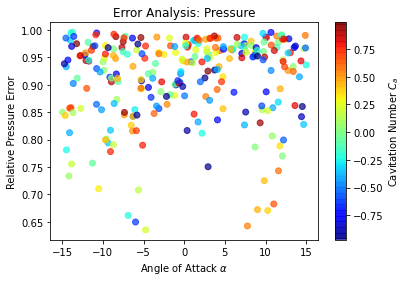

In [98]:
c = cav
plt.scatter(angles,p_error, c=c, cmap='jet', alpha=0.7)
plt.xlabel('Angle of Attack' ' ' r'$\alpha$')
plt.ylabel("Relative Pressure Error")
cbar = plt.colorbar(shrink=1.0)
cbar.ax.set_ylabel('Cavitation Number' ' ' r'$C_a$')
cbar.ax.tick_params(labelsize=10)
plt.title('Error Analysis: Pressure')
plt.savefig('PERRORAoA_perror_Cav', dpi=80)
plt.show()

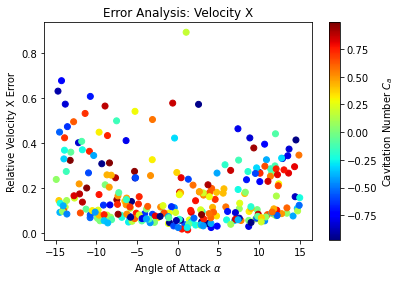

In [99]:
c = cav
plt.scatter(angles,v_x_error, c=c, cmap='jet', alpha=1.0)
plt.xlabel('Angle of Attack' ' ' r'$\alpha$')
plt.ylabel("Relative Velocity X Error")
cbar = plt.colorbar(shrink=1.0)
cbar.ax.set_ylabel('Cavitation Number' ' ' r'$C_a$')
cbar.ax.tick_params(labelsize=10)
plt.title('Error Analysis: Velocity X')
plt.savefig('ErrorAoA_Vxerror_Cav', dpi=80)
plt.show()

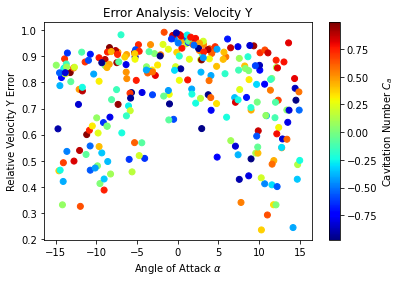

In [103]:
c = cav
plt.scatter(angles,v_y_error, c=c, cmap='jet', alpha=1.0)
plt.xlabel('Angle of Attack' ' ' r'$\alpha$')
plt.ylabel("Relative Velocity Y Error")
cbar = plt.colorbar(shrink=1.0)
cbar.ax.set_ylabel('Cavitation Number' ' ' r'$C_a$')
cbar.ax.tick_params(labelsize=10)
plt.title('Error Analysis: Velocity Y')
plt.savefig('AoA_Vyerror_Cav', dpi=80)
plt.show()

In [ ]:
c

In [ ]:
inputs_cpu[:,0,0,0]

tensor([77.5300], device='cuda:0')

In [ ]:
inputs_cpu[:,1,0,0]

tensor([0.7754], device='cuda:0')

In [ ]:
torch.arctan(inputs_cpu[:,1,0,0]/inputs_cpu[:,0,0,0])*180/torch.tensor(math.pi)

tensor([0.5730], device='cuda:0')